# Ungraded Lab - Deploy a Machine Learning Model

Welcome to this ungraded lab! If you are reading this it means you did the setup properly, nice work!

In this lab you will see what deploying a real machine learning model feels like. To be more concrete, you will deploy a computer vision model that detects common objects in pictures. Usually deploying a model is one of the last steps involving the machine learning lifecycle but we thought it would be exciting to get to deploy a model right away. With this in mind you will be using a pretrained model called [`YOLOV3`](https://pjreddie.com/darknet/yolo/). This model is really fast and yields accurate results for the task of object detection.

First you will look at the model itself and then you will use [`fastAPI`](https://fastapi.tiangolo.com/) to deploy it.

## Object Detection YOLOV3

### Inspect the images

Before checking the model let's take a look at some images of common objects that YOLOV3 is able to detect. These images are part of the [`ImageNet`](http://www.image-net.org/index) dataset.

In [1]:
from IPython.display import Image, display


Displaying image: apple.jpg


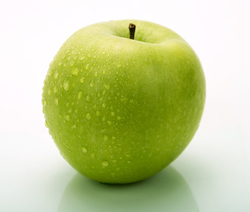


Displaying image: clock.jpg


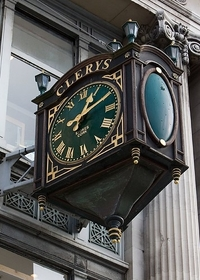


Displaying image: oranges.jpg


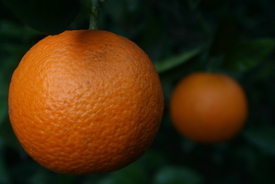


Displaying image: car.jpg


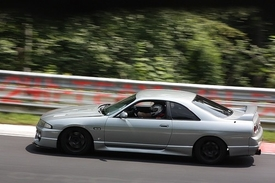

In [2]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Overview of the model

Now that you know how the images look like, let's try and see if the model is able to detect and classify them correctly.

For this you will be using [`cvlib`](https://www.cvlib.net/), which is a very simple but powerful library for object detection that is fueled by [`OpenCV`](https://docs.opencv.org/4.5.1/) and [`Tensorflow`](https://www.tensorflow.org/).

In concrete you will use the [`detect_common_objects`](https://docs.cvlib.net/object_detection/) function, which given an image represented as a [`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) returns:

- `bbox`: list of list containing bounding box co-ordinates for detected objects. 

        Example:
    
    ```python
        [[32, 76, 128, 192], [130, 83, 220, 185]]
    ```

- `label`: list of labels for detected objects.
    
        Example:
    ```python
        ['apple', 'apple']
    ```


- `conf`: list of confidence scores for detected objects.
        Example:
    ```python
        [0.6187325716018677, 0.42835739254951477]
    ```

### Create detect_and_draw_box function

Let's define the `detect_and_draw_box` function which, given a **filename** of a file on your system, a **model** and a **confidence level**, detects common objects in the image and saves a new image displaying the bounding boxes alongside the detected object.

You might ask yourself why does this function receive the model as a parameter? What models are there to choose from?

The answer is that `detect_common_objects` uses the `yolov3` model by default but another much tinier version of it can also be selected. 

This model is known as `yolov3-tiny`. It is designed for constrained environments that cannot store big models and as a result of this, it presents the tradeoff that it yields less accuracy than the full version. However, it still works pretty well. Going forward we recommend you stick to it since it is a lot smaller than the regular `yolov3` and downloading its pretrained weights takes a lot less time. But if your internet is good we recommend to also try out the default version.

In [3]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    print("====="*5)
    # Print current image's filename
    print(f"Image processed: {filename}\n")
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: apple.jpg



Detected object: apple with confidence level of 0.5717206597328186



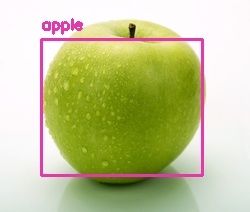

Image processed: clock.jpg

Detected object: clock with confidence level of 0.9683184623718262



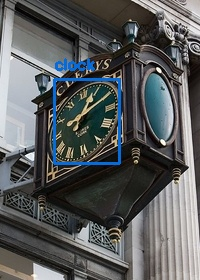

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185588836669922

Detected object: orange with confidence level of 0.5561690330505371



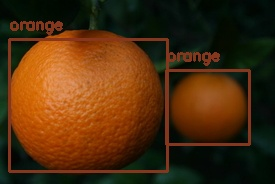

Image processed: car.jpg

Detected object: car with confidence level of 0.6325406432151794



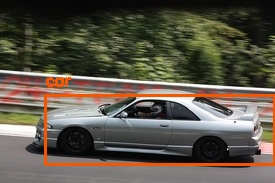

In [4]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## Changing the confidence level

Looks like the object detection went fairly well. Let's try it out on a more difficult image containing several objects:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818482041358948

Detected object: orange with confidence level of 0.5346484184265137

Detected object: orange with confidence level of 0.515099287033081



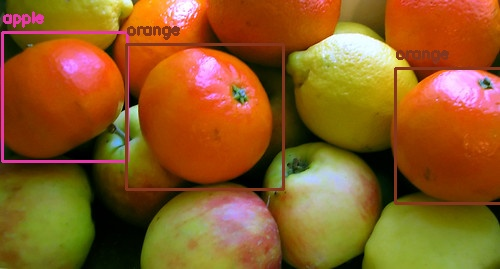

In [5]:
detect_and_draw_box("fruits.jpg")

Looks like the **model failed to detect** several fruits and **misclassified** an orange as an apple. This might seem strange since it was able to detect one apple before so one might think it knows how an apple looks like.

What probably happened is that the model **did** detect the other fruits but with a confidence level lower than 0.5. Let's test this hypothesis:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818482041358948

Detected object: orange with confidence level of 0.5346484184265137

Detected object: orange with confidence level of 0.515099287033081

Detected object: apple with confidence level of 0.34759870171546936

Detected object: orange with confidence level of 0.32876086235046387

Detected object: apple with confidence level of 0.31244686245918274

Detected object: orange with confidence level of 0.27986079454421997

Detected object: orange with confidence level of 0.2749977707862854

Detected object: apple with confidence level of 0.2744504511356354

Detected object: orange with confidence level of 0.21419058740139008



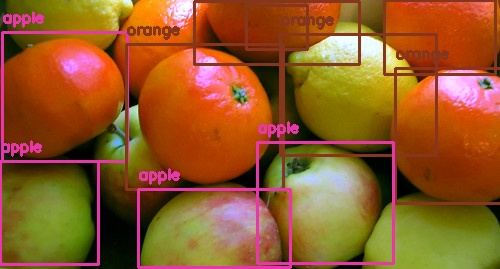

In [6]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

By lowering the confidence level the model successfully most of the fruits. However the confidence level was really low. In general you should be careful when lowering or increasing these kind of parameters as changing them might yield undesired results.

As for the orange that the model misclassified as an apple, it server as a reminder that these models are not perfect and this should be considered when using them for tasks in production. **Remember, selecting an appropiate model is a really important but highly complex task!**

## Deploying the model using fastAPI


### Put your object detection model in a server

Now that you know how the model works it is time for you to deploy it! Aren't you excited? :)

Before doing it let's quickly recap some important concepts and how they translate to `fastAPI`. 


### Some concept clarifications

#### Client-Server model

When talking about **deploying**, what is usually meant is to put all of the software required for predicting in a `server`. By doing this, a `client` can interact with the model by sending `requests` to the server. 

This client-server interaction is out of the scope of this notebook but there are a lot of resources that you can use to understand it better. Just type `client server` in the search engine of your choice and you will get a lot of results.

The important things you need to understand is that the Machine Learning model lives in a server waiting for some client to ask it to return predictions. The client should provide the information (values for the features or even images) that the model needs in order to make a prediction or predictions (it is common to batch many predictions in a single request). After using this information to predict, the server will return the actual prediction to the client, who can use it in any desired way.

To create a server on fastAPI all you need to do is to create an instance of the `FastAPI` class:

```python
app = FastAPI()
```

Then you will use this instance to create endpoints that will handle the logic for predicting (more on this next). Once all the code is in place to run the server you only need to use the command:

```python
uvicorn.run(app)
```

All the code of your API will be created using fastAPI but the serving is done using [`uvicorn`](https://www.uvicorn.org/), which is a really fast ASGI (Asynchronous Server Gateway Interface) server implementation. Both technologies are closely interconnected and you don't need to understand the implementation details. Knowing that uvicorn handles the serving is enough.


#### Endpoints

You can host multiple Machine Learning models in the same server. For this to work you can assign a different `endpoint` to each model so you always know what model is being used. An endpoint is represented by a pattern in the `URL`. As an example if you have a website called `myawesomemodel.com` you could have three different models in the following endpoints:

- `myawesomemodel.com/count-cars/`
- `myawesomemodel.com/count-apples/`
- `myawesomemodel.com/count-plants/`

Each model would do what the pattern suggests.

In fastAPI you define an endpoint by creating a function that will handle all of the logic for that endpoint and [decorating](https://www.python.org/dev/peps/pep-0318/) it with a function that contains information of the HTTP method allowed (more on this next) and the pattern in the URL that it will use.

The following example shows how allow a HTTP GET request for the endpoint "/my-endpoint":

```python
@app.get("/my-endpoint")
def handle_endpoint():
    ...
    ...
```


#### HTTP Requests

If you are wondering how the client and the server manage to communicate with each other the answer is through a protocol called `HTTP`. You can research more on your own if you are not familiar with this concept but the important concept to understand is that this communication between client and server uses some verbs to denote common actions. Two very common of these such verbs are:

- `GET`
- `POST`

If your client does a `GET request` to an endpoint of a server you will get some information from this endpoint without the need to provide additional information. In the case of a `POST request` you are explicitly telling the server that you will provide some information for it that must be processed in some way.

Interactions with Machine Learning models living on endpoints are usually done via a `POST request` since you need to provide the information that the prediction is gonna be computed for.

You already saw an example of a GET request previously, now take a look at a POST request:

```python
@app.post("/my-other-endpoint")
def handle_other_endpoint(param1: int, param2: str):
    ...
    ...

```

Notice that in the case of the POST request, the handler function has some parameters. This is because unlike GET, POST requests expect the client to provide some information to it. In this case an integer and a string are required for the server to correctly handle this request.



### Why fastAPI?

The reason that you are doing this exercise using fastAPI is that it enables to create web servers to host your models very easily. Aditional to this, it is extremely fast and it has a built-in client that can be used to interact with the server. To use it you will need to visit the **"/docs"** endpoint. Isn't that convenient? 

Enough chatter, let's get going!

In [7]:
import io
import os
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [8]:
# Assign an instance of the FastAPI class to the variable "app"
# You will interact with you api using this instance
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to the /docs endpoint."


# This endpoint handles all the logic necessary for the object detection to work
# It requires the desired model and the image in which to perform object detection
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read you image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes in a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_submitted/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_submitted/{filename}', mode="rb")
    
    # Return the image as a stream specyfing media type
    return StreamingResponse(file_image, media_type="image/jpeg")

By running the following cell you will spin up the server! Head over to [http://localhost:8000/](http://localhost:8000/) afterwards to see it in action.

You should know that by doing so this notebook will block until you manually interrupt the kernel. You can do this by clicking on the `Kernel` tab and then on `Interrupt`. Although there is no more code for you to run on this notebook it is worth mentioning.

You might also wonder about the `nest_asyncio.apply()` line. FastAPI (and servers in general) are not meant to be run within an interactive environment but as python scripts. To overcome this [`nest-asyncio`](https://pypi.org/project/nest-asyncio/) is used.

In [11]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()


# Host depends on the setup you selected (docker or virtual env)
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [29]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     172.17.0.1:56080 - "GET / HTTP/1.1" 200 OK
INFO:     172.17.0.1:56080 - "GET /favicon.ico HTTP/1.1" 404 Not Found


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [29]


It is awesome that fastAPI allows you to interact with your API through its built-in client. However you might wonder how can I interact with my API using regular code and not some UI.

We also have provided a notebook in which you can check how a minimal client in Python looks like. For this, leave the server running (don't interrupt the kernel or close this window) and open the `client.ipynb` notebook.

**Congratulations on finishing this ungraded lab!** These are toy examples of how a real server and client might look like. Although there are some vital parts missing this is pretty much how this will work on a real prodcution environment. We hope you feel more familiar with the process of deploying a Machine Learning model and encourage you to keep studying.